In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

In [10]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<AxesSubplot:xlabel='Contract', ylabel='count'>

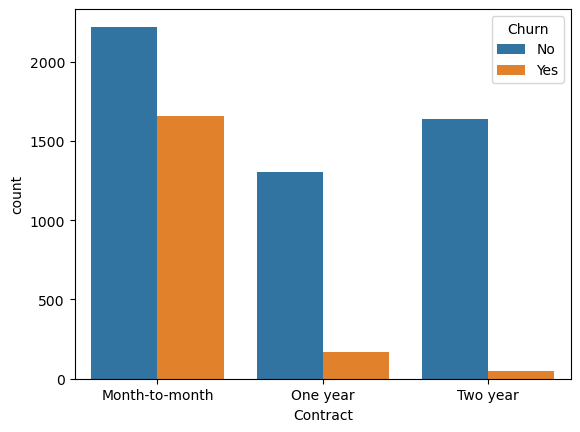

In [3]:
sns.countplot(data=df, x = 'Contract', hue='Churn')

<AxesSubplot:xlabel='tenure', ylabel='count'>

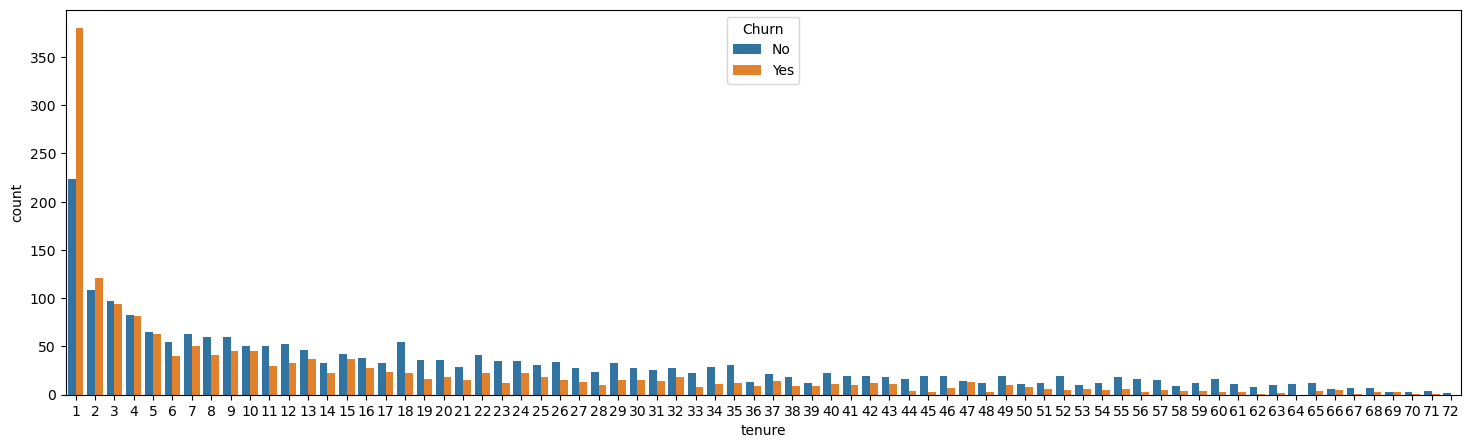

In [4]:
plt.figure(figsize=(18, 5))
sns.countplot(data=df[df['Contract'] == 'Month-to-month'], x = 'tenure', hue='Churn')

<AxesSubplot:xlabel='tenure', ylabel='count'>

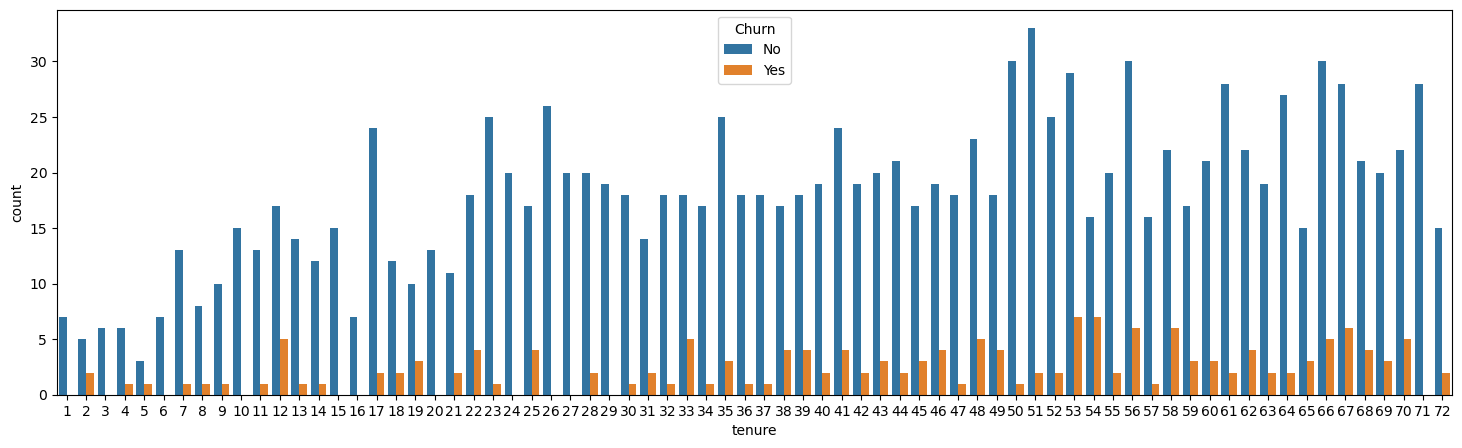

In [5]:
plt.figure(figsize=(18, 5))
sns.countplot(data=df[df['Contract'] == 'One year'], x = 'tenure', hue='Churn')

<AxesSubplot:xlabel='tenure', ylabel='count'>

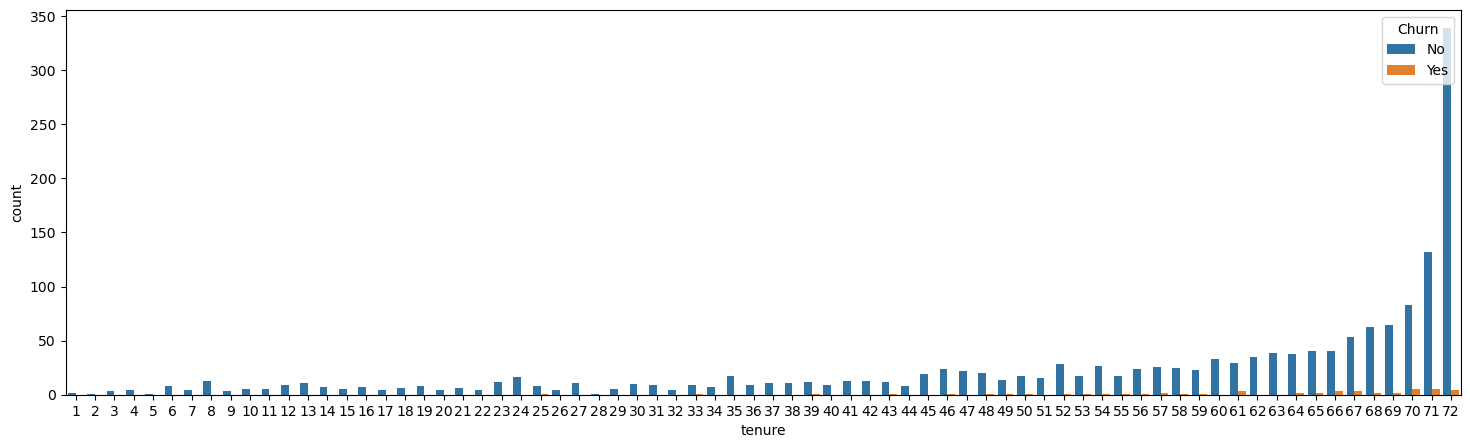

In [6]:
plt.figure(figsize=(18, 5))
sns.countplot(data=df[df['Contract'] == 'Two year'], x = 'tenure', hue='Churn')

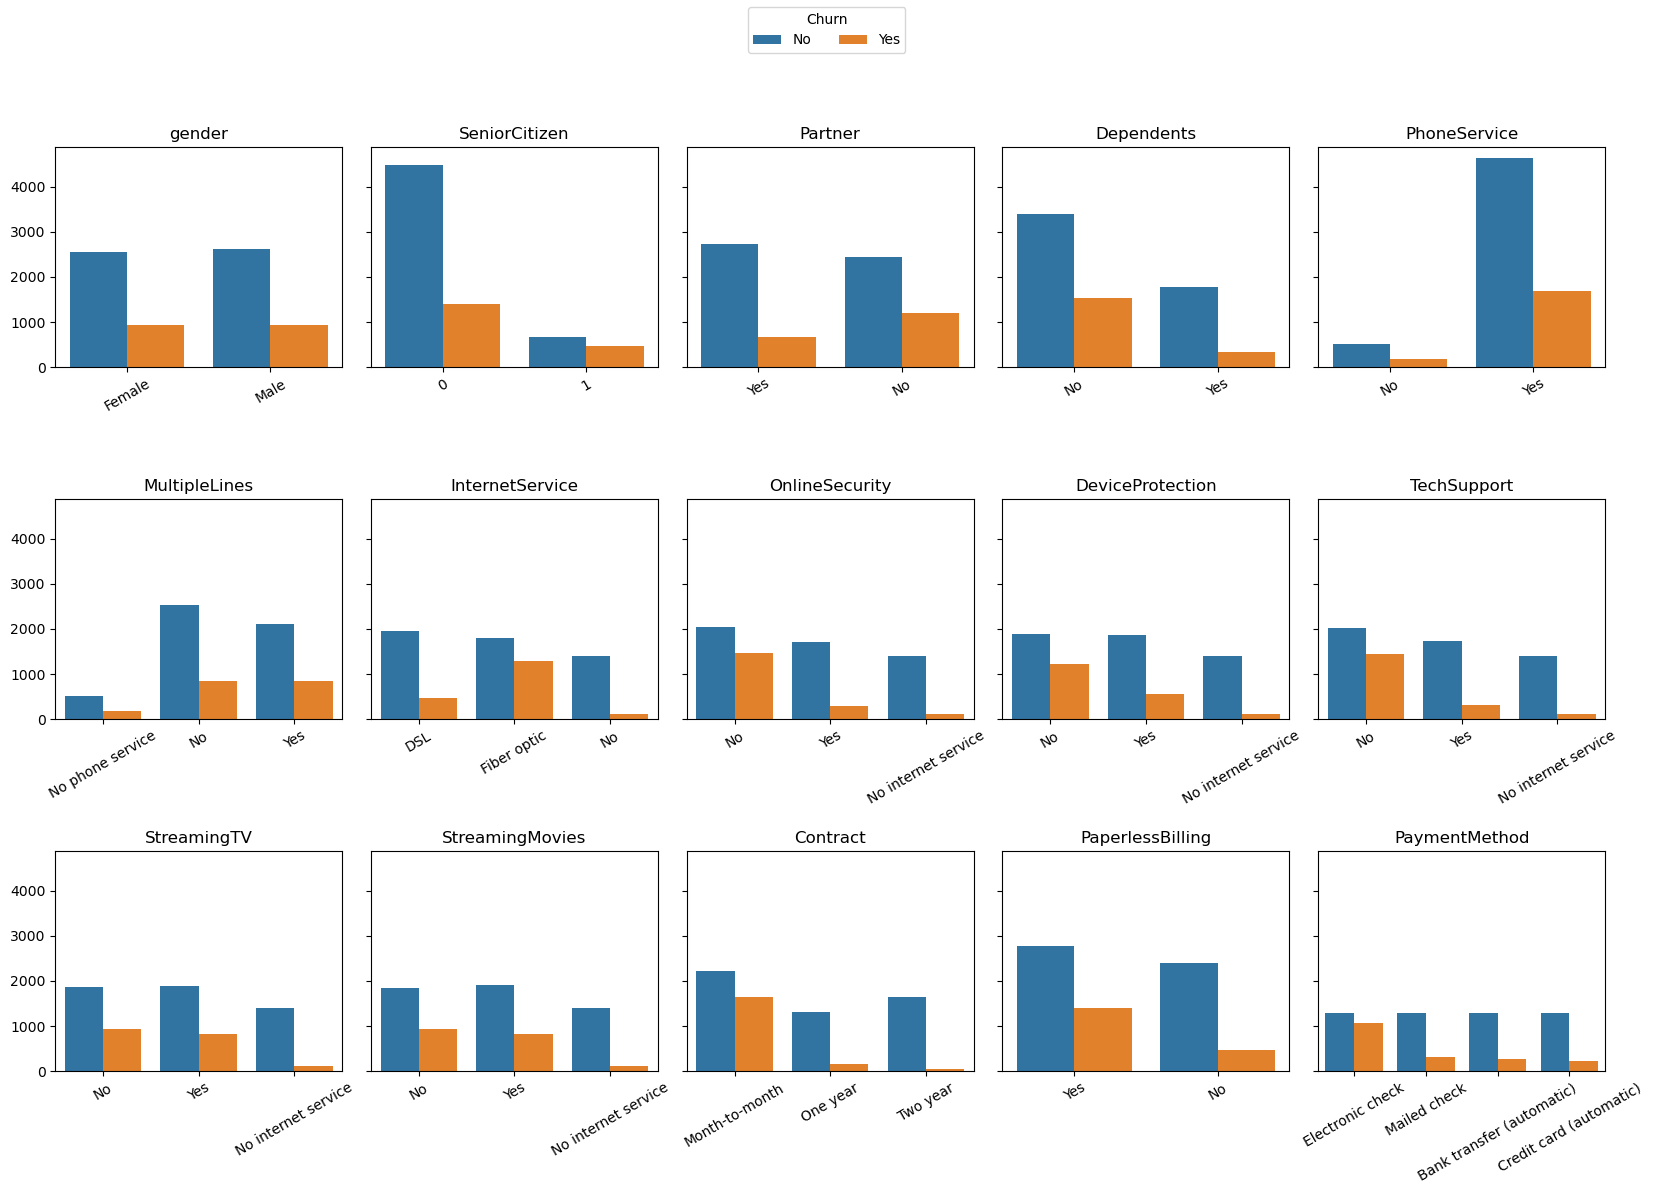

In [7]:
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharey=True)
axes = axes.flatten()

for index, column in enumerate(cols):
    ax = axes[index]
    sns.countplot(data=df, x=column, hue='Churn', ax=ax)
    fig.subplots_adjust(wspace=0.1, hspace=0.6)
    ax.tick_params(axis='x', rotation=30)
    ax.set_xlabel(None) 
    ax.set_ylabel(None) 
    ax.get_legend().remove()
    ax.set_title(column)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title='Churn')

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, recall_score, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn import tree

In [18]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']
X = pd.get_dummies(X, drop_first=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

In [ ]:
class_model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
recall_scorer = make_scorer(recall_score, pos_label='Yes')

grid_model = GridSearchCV(class_model, param_grid=param_grid, scoring=recall_scorer, cv=5)

grid_model.fit(X_train, y_train)

In [23]:
grid_model.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

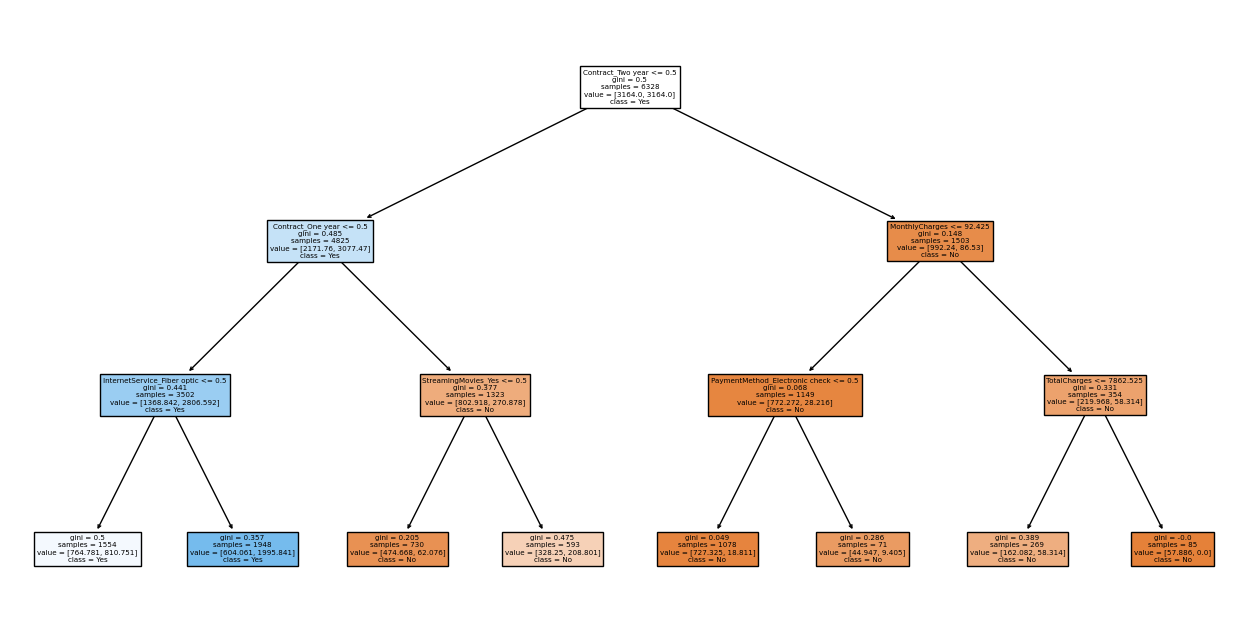

In [ ]:


plt.figure(figsize=(16, 8))
tree.plot_tree(grid_model.best_estimator_, filled=True, feature_names=X_train.columns, class_names=['No', 'Yes'])
plt.show()

In [28]:
y_prediction = grid_model.predict(X_test)

In [30]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

          No       0.93      0.59      0.72       517
         Yes       0.44      0.87      0.58       187

    accuracy                           0.67       704
   macro avg       0.68      0.73      0.65       704
weighted avg       0.80      0.67      0.69       704



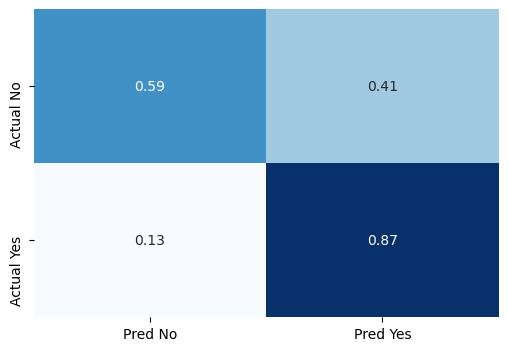

In [39]:
cm_normalize = confusion_matrix(y_test, y_prediction, labels=['No', 'Yes'], normalize='true')

cm_df = pd.DataFrame(cm_normalize,
                     index=['Actual No', 'Actual Yes'],
                     columns=['Pred No', 'Pred Yes'])

plt.figure(figsize=(6,4))
ax = sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)

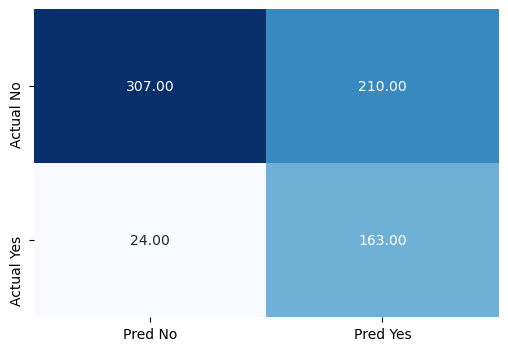

In [40]:
cm = confusion_matrix(y_test, y_prediction)

cm_df = pd.DataFrame(cm,
                     index=['Actual No', 'Actual Yes'],
                     columns=['Pred No', 'Pred Yes'])

plt.figure(figsize=(6,4))
ax = sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)

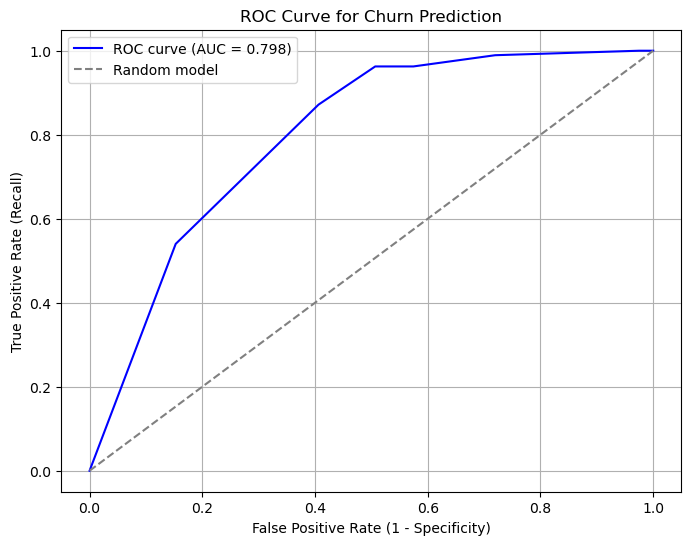

AUC Score: 0.798


In [ ]:
y_proba = grid_model.best_estimator_.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label='Yes')

auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random model')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Churn Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC Score: {auc_score:.3f}")